
# **IN THIS NOTEBOOK I WILL PERFORM MULTIVARIATE TIME SERIES ANALYSIS USING THE LSTM (LONG-SHORT TERM MEMORY).**

In [1]:
#Importing libraries
import pandas as pd # dataframes data processing
import numpy as np #working with arrays
import matplotlib as mpl # visualisation
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split #splitting into training and testing data
from keras.preprocessing.sequence import TimeseriesGenerator # creation of time series model and data preprocessing
from sklearn.preprocessing import MinMaxScaler , StandardScaler # Scaling values within a range
import tensorflow as tf #working with neural networks
import numpy as np

IMPORTING DATASET

In [2]:
#Converting date column of object type to date column of date type
dateparse= lambda dates: pd.datetime.strptime(dates,'%d-%m-%Y')
data=pd.read_csv('MAster_methanol.csv',parse_dates=['Date'],date_parser=dateparse,usecols=['Date','India Price','Asia Price','Rotterdam Price','US Domestic Price'])

<ipython-input-2-ec016fa0679a>:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  dateparse= lambda dates: pd.datetime.strptime(dates,'%d-%m-%Y')


In [3]:
#data.dtypes
data.index=pd.to_datetime(data['Date'],format='%d-%m-%Y')

In [4]:
data.head()

,Date,India Price,Asia Price,Rotterdam Price,US Domestic Price
Date,,,,,
2005-10-07,2005-10-07,240.0,232.5,210.4,84.63
2005-10-14,2005-10-14,240.0,232.5,213.5,81.00
2005-10-21,2005-10-21,242.5,235.0,214.0,81.00
2005-10-28,2005-10-28,242.5,232.5,213.0,84.63
2005-11-04,2005-11-04,250.0,242.5,215.5,86.45


In [5]:
del data['Date']

In [6]:
data.head()

,India Price,Asia Price,Rotterdam Price,US Domestic Price
Date,,,,
2005-10-07,240.0,232.5,210.4,84.63
2005-10-14,240.0,232.5,213.5,81.00
2005-10-21,242.5,235.0,214.0,81.00
2005-10-28,242.5,232.5,213.0,84.63
2005-11-04,250.0,242.5,215.5,86.45


SPLITTING DATA INTO TRAIN AND TEST SETS

In [65]:
X=data[['India Price','Asia Price','Rotterdam Price','US Domestic Price']]
y=data[['India Price']]

In [66]:
train=X[0:636]
test=X[636:]

In [67]:
train.tail()

,India Price,Asia Price,Rotterdam Price,US Domestic Price
Date,,,,
2018-02-02,367.0,408.0,354.5,127.93
2018-02-09,359.0,387.0,343.1,127.93
2018-02-16,347.0,387.0,333.4,127.93
2018-02-23,342.0,381.0,320.5,127.93
2018-03-02,336.0,380.0,316.2,119.20


FEATURE SCALING OF DATA

In [68]:
scaler= MinMaxScaler()

In [69]:
scaled_train=scaler.fit_transform(train)

In [70]:
win_length=12 # 3 months data or 12 weeks
batch_size=3 #training 3 weeks data together 
n_features=4 # there are 4 inputs
train_generator=TimeseriesGenerator(scaled_train,scaled_train,length=win_length,sampling_rate=1,batch_size=batch_size)

IMPORTING LIBRARIES TO IMPLEMENT LSTM

In [71]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [72]:
model=Sequential()

Return sequences -need hidden state for each of the input data.

Hidden states are technically speaking inputs to whatever we do at a given step, and they can only be computed by looking at data at previous time steps.

Leaky ReLU has a small slope for negative values, instead of altogether zero. Leaky relu as the name suggests adds a small leak for -ve values (alpha) rather than making them 0.

In [73]:
model.add(tf.keras.layers.LSTM(128,input_shape=(win_length,n_features),return_sequences=True)) # creating an lstm layer with input shape containing window size and 4 iinputs
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model.add(tf.keras.layers.LSTM(128,return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model.add(tf.keras.layers.Dropout(0.3)) #Dropout is a technique used to prevent a model from overfitting
model.add(tf.keras.layers.LSTM(64,return_sequences=False)) #false returns only 1 hidden state for all observations tgther
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(1)) #deeply connected with its preceding layer final layer

In [74]:
model.compile(optimizer='adam',loss='mse',metrics=[tf.metrics.MeanAbsoluteError()])

In [75]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 12, 128)           68096     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 12, 128)           0         
                                                                 
 lstm_4 (LSTM)               (None, 12, 128)           131584    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 12, 128)           0         
                                                                 
 dropout_2 (Dropout)         (None, 12, 128)           0         
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_3 (Dropout)         (None, 64)               

In [76]:
history = model.fit_generator(train_generator,epochs=50,shuffle=False) 

Epoch 1/50


<ipython-input-76-cb187e12653e>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,epochs=50,shuffle=False)


208/208 [==============================] - 14s 36ms/step - loss: 0.0359 - mean_absolute_error: 0.1356
Epoch 2/50
208/208 [==============================] - 7s 31ms/step - loss: 0.0293 - mean_absolute_error: 0.1291
Epoch 3/50
208/208 [==============================] - 6s 31ms/step - loss: 0.0247 - mean_absolute_error: 0.1181
Epoch 4/50
208/208 [==============================] - 7s 36ms/step - loss: 0.0208 - mean_absolute_error: 0.1095
Epoch 5/50
208/208 [==============================] - 7s 36ms/step - loss: 0.0165 - mean_absolute_error: 0.0995
Epoch 6/50
208/208 [==============================] - 6s 31ms/step - loss: 0.0154 - mean_absolute_error: 0.0967
Epoch 7/50
208/208 [==============================] - 6s 31ms/step - loss: 0.0139 - mean_absolute_error: 0.0928
Epoch 8/50
208/208 [==============================] - 6s 31ms/step - loss: 0.0123 - mean_absolute_error: 0.0865
Epoch 9/50
208/208 [==============================] - 7s 36ms/step - loss: 0.0098 - mean_absolute_error: 0.0763
Ep

FORECASTING FUTURE VALUES

Predicting 1st week of test set using last 12 weeks of Train set

In [77]:
train[-12:]

,India Price,Asia Price,Rotterdam Price,US Domestic Price
Date,,,,
2017-12-08,401.0,406.0,305.80,104.55
2017-12-15,415.0,420.0,322.60,104.55
2017-12-22,432.0,425.0,329.90,104.55
2018-01-05,430.0,409.0,340.13,121.55
2018-01-12,422.0,415.0,356.30,121.55
2018-01-19,396.0,400.0,354.90,121.55
2018-01-26,383.0,400.0,361.70,121.55
2018-02-02,367.0,408.0,354.50,127.93
2018-02-09,359.0,387.0,343.10,127.93


In [78]:
last_scaled_train=train[-12:]
last_train=scaler.fit_transform(last_scaled_train)
last_train

array([[0.67708333, 0.57777778, 0.        , 0.        ],
       [0.82291667, 0.88888889, 0.30053667, 0.        ],
       [1.        , 1.        , 0.43112701, 0.        ],
       [0.97916667, 0.64444444, 0.61413238, 0.72711719],
       [0.89583333, 0.77777778, 0.90339893, 0.72711719],
       [0.625     , 0.44444444, 0.8783542 , 0.72711719],
       [0.48958333, 0.44444444, 1.        , 0.72711719],
       [0.32291667, 0.62222222, 0.87119857, 1.        ],
       [0.23958333, 0.15555556, 0.66726297, 1.        ],
       [0.11458333, 0.15555556, 0.49373882, 1.        ],
       [0.0625    , 0.02222222, 0.26296959, 1.        ],
       [0.        , 0.        , 0.18604651, 0.62660393]])

In [79]:
n_input=12 
n_features=4
last_train_batch=last_train.reshape((1,n_input,n_features))

In [80]:
train.head()

,India Price,Asia Price,Rotterdam Price,US Domestic Price
Date,,,,
2005-10-07,240.0,232.5,210.4,84.63
2005-10-14,240.0,232.5,213.5,81.00
2005-10-21,242.5,235.0,214.0,81.00
2005-10-28,242.5,232.5,213.0,84.63
2005-11-04,250.0,242.5,215.5,86.45


In [81]:
data[624:648].count()

India Price          24
Asia Price           24
Rotterdam Price      24
US Domestic Price    24
dtype: int64

In [89]:
scaled_train

array([[0.19170984, 0.17032967, 0.26264013, 0.16366551],
       [0.19170984, 0.17032967, 0.26973233, 0.1442693 ],
       [0.19689119, 0.17582418, 0.27087623, 0.1442693 ],
       ...,
       [0.4134715 , 0.50989011, 0.54404027, 0.39503072],
       [0.40310881, 0.4967033 , 0.51452757, 0.39503072],
       [0.39067358, 0.49450549, 0.50469   , 0.34838365]])

In [90]:
curr_batch.shape

(1, 12, 4)

In [91]:
test_pred=test[0:12]
test_pred

,India Price,Asia Price,Rotterdam Price,US Domestic Price
Date,,,,
2018-03-09,341.0,395.0,323.00,119.2
2018-03-16,374.0,401.0,315.60,119.2
2018-03-23,390.0,400.0,314.20,119.2
2018-03-30,384.0,409.0,310.13,119.2
2018-04-06,422.0,410.0,317.88,119.2
2018-04-13,416.0,415.0,323.30,119.2
2018-04-20,394.0,421.0,318.00,119.2
2018-04-27,404.0,423.0,310.30,119.2
2018-05-04,399.0,420.0,314.20,119.2


FORECASTING VALUES


In [92]:
sl = curr_batch[0,:1,1:]
sl=sl.ravel()
# np.append(curr_pred,sl,axis=1)
sl

array([0.55164835, 0.48089682, 0.27010419])

ROLLING PREDICTIONS OF FUTURE VALUES

FUNCTION THAT DOES ROLLING PREDICTIONS

In [84]:
def pred(i,curr_pred,curr_batch):
  sl=curr_batch[0,i:(i+1),1:]
  sl=sl.ravel()
  curr_pred=np.append(curr_pred,sl)
  return curr_pred

In [85]:
type(sl),type(curr_pred)

(numpy.ndarray, numpy.ndarray)

In [86]:
curr_pred

array([0.45274866], dtype=float32)

HERE I HAVE DONE ROLLING PREDICTIONS ,TAKING LAST 12 VALUES OF TRAIN SET AS INPUT AND APPENDING THE NEWLY PREDICTED VALUES

MY TEST SET HAS VALUES OF LAST 4 YEARS OF DATASET ,I HAVE CREATED 3 TEST DATA SUBSETS AND TAKEN LAST TWELVE WEEKS OF DATA FROM THEM TO DO ROLLING PREDICTIONS FOR THE NEXT TWELVE WEEKS OF DATA

In [87]:
test_predictions=[]
n_input=12
n_features=4

first_batch=scaled_train[-n_input:]
curr_batch=first_batch.reshape((1,n_input,n_features))
for i in range(0,len(test_pred)):#len(test_pred)
  curr_pred=model.predict(curr_batch)[0]
  test_predictions.append(curr_pred)
  slc=pred(i,curr_pred,curr_batch)
  curr_batch=np.append(curr_batch[:,1:,:],[[slc]],axis=1)

1/1 [==============================] - 0s 26ms/step


In [88]:
first_batch.shape

(12, 4)

FIRST TWELVE WEEKS OF TEST_SET PREDICTIONS

In [93]:
test_predictions

[array([0.43045327], dtype=float32),
 array([0.4517791], dtype=float32),
 array([0.4838407], dtype=float32),
 array([0.5005835], dtype=float32),
 array([0.4989325], dtype=float32),
 array([0.47206438], dtype=float32),
 array([0.4412351], dtype=float32),
 array([0.43936235], dtype=float32),
 array([0.4787646], dtype=float32),
 array([0.4681193], dtype=float32),
 array([0.45377624], dtype=float32),
 array([0.46023184], dtype=float32)]

In [94]:
curr_batch

array([[[0.43045327, 0.55164835, 0.48089682, 0.27010419],
        [0.4517791 , 0.59340659, 0.53603294, 0.27010419],
        [0.4838407 , 0.57142857, 0.59643102, 0.36094042],
        [0.50058353, 0.53846154, 0.60878518, 0.36094042],
        [0.49893251, 0.50989011, 0.56623198, 0.39503072],
        [0.47206438, 0.4967033 , 0.51452757, 0.39503072],
        [0.4412351 , 0.55164835, 0.48089682, 0.27010419],
        [0.43936235, 0.57142857, 0.59643102, 0.36094042],
        [0.47876459, 0.50989011, 0.56623198, 0.39503072],
        [0.46811929, 0.55164835, 0.48089682, 0.27010419],
        [0.45377624, 0.50989011, 0.56623198, 0.39503072],
        [0.46023184, 0.50989011, 0.56623198, 0.39503072]]])

In [95]:
# test_predictions.size
type(test_predictions)

list

In [96]:
test_predictions=np.array(test_predictions)
type(test_predictions)

numpy.ndarray

In [97]:
scaled_train.shape

(636, 4)

In [98]:
test.head(12)

,India Price,Asia Price,Rotterdam Price,US Domestic Price
Date,,,,
2018-03-09,341.0,395.0,323.00,119.2
2018-03-16,374.0,401.0,315.60,119.2
2018-03-23,390.0,400.0,314.20,119.2
2018-03-30,384.0,409.0,310.13,119.2
2018-04-06,422.0,410.0,317.88,119.2
2018-04-13,416.0,415.0,323.30,119.2
2018-04-20,394.0,421.0,318.00,119.2
2018-04-27,404.0,423.0,310.30,119.2
2018-05-04,399.0,420.0,314.20,119.2


FEATURE SCALING VALUES

In [99]:
testing=X[636:648]
testing_scaled=scaler.fit_transform(testing)

In [100]:
curr_batch=curr_batch.reshape(n_input,n_features)
curr_batch.shape

(12, 4)

In [101]:
true_predictions=scaler.inverse_transform(curr_batch)
true_predictions

array([[375.86671492, 412.1010989 , 321.03193091, 119.47010419],
       [377.59410688, 413.3956044 , 322.28186685, 119.47010419],
       [380.19109702, 412.71428571, 323.65109128, 119.56094042],
       [381.54726589, 411.69230769, 323.93115992, 119.56094042],
       [381.41353336, 410.80659341, 322.96647907, 119.59503072],
       [379.23721445, 410.3978022 , 321.79433997, 119.59503072],
       [376.74004272, 412.1010989 , 321.03193091, 119.47010419],
       [376.58835012, 412.71428571, 323.65109128, 119.56094042],
       [379.77993208, 410.80659341, 322.96647907, 119.59503072],
       [378.91766277, 412.1010989 , 321.03193091, 119.47010419],
       [377.75587547, 410.80659341, 322.96647907, 119.59503072],
       [378.27877909, 410.80659341, 322.96647907, 119.59503072]])

In [102]:
df_predictions=testing
df_predictions
df_predictions['IndiaPrice_pred']=true_predictions[:,0]
df_predictions

<ipython-input-102-fb40b649910a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_predictions['IndiaPrice_pred']=true_predictions[:,0]


,India Price,Asia Price,Rotterdam Price,US Domestic Price,IndiaPrice_pred
Date,,,,,
2018-03-09,341.0,395.0,323.00,119.2,375.866715
2018-03-16,374.0,401.0,315.60,119.2,377.594107
2018-03-23,390.0,400.0,314.20,119.2,380.191097
2018-03-30,384.0,409.0,310.13,119.2,381.547266
2018-04-06,422.0,410.0,317.88,119.2,381.413533
2018-04-13,416.0,415.0,323.30,119.2,379.237214
2018-04-20,394.0,421.0,318.00,119.2,376.740043
2018-04-27,404.0,423.0,310.30,119.2,376.588350
2018-05-04,399.0,420.0,314.20,119.2,379.779932


ACTUAL VALUES VS PREDICTED ASIA VALUE PRICES

In [103]:
df_predictions[['India Price','IndiaPrice_pred']]

,India Price,IndiaPrice_pred
Date,,
2018-03-09,341.0,375.866715
2018-03-16,374.0,377.594107
2018-03-23,390.0,380.191097
2018-03-30,384.0,381.547266
2018-04-06,422.0,381.413533
2018-04-13,416.0,379.237214
2018-04-20,394.0,376.740043
2018-04-27,404.0,376.588350
2018-05-04,399.0,379.779932


<Axes: xlabel='Date'>

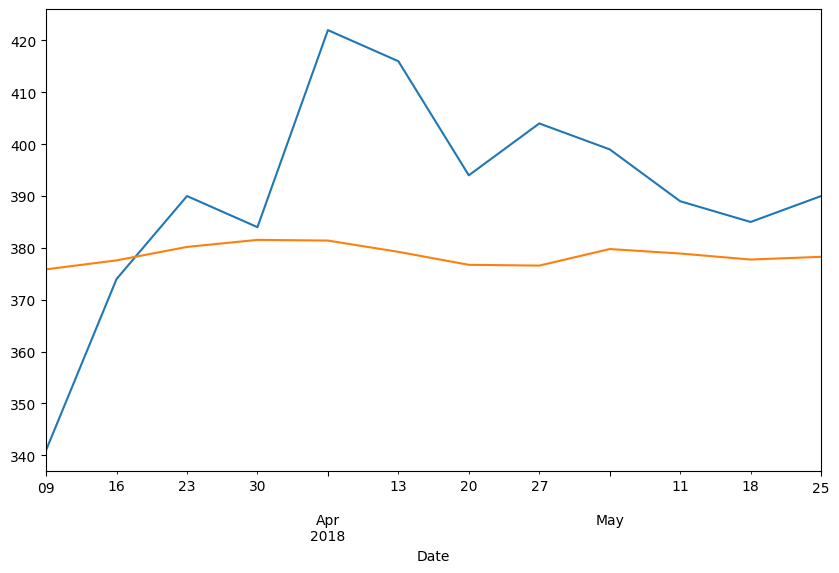

In [104]:
df_predictions['India Price'].plot(figsize=(10,6))
df_predictions['IndiaPrice_pred'].plot()

In [105]:
from sklearn.metrics import mean_squared_error
from math import sqrt
error=sqrt(mean_squared_error(df_predictions['India Price'],df_predictions['IndiaPrice_pred']))
print(error)

22.434781667513604


In [146]:
# Calculate range of test set
range_test = test.max() - test.min()

# Calculate Normalized RMSE
normalized_rmse = error / range_test

print(normalized_rmse)

India Price          0.070218
Asia Price           0.079556
Rotterdam Price      0.089811
US Domestic Price    0.316206
dtype: float64


In [106]:
curr_batch.shape

(12, 4)

TAKING LAST TWELVE VALUES OF TEST SUBSET 1 TO PREDICT VALUES OF NEXT 12 WEEKS OF 2ND TEST SUBSET

In [107]:
test['2019-03-01':'2019-06-01']
test2_input=data[675:687]
test2_input_scaled=scaler.fit_transform(test2_input)

In [108]:
test2_input

,India Price,Asia Price,Rotterdam Price,US Domestic Price
Date,,,,
2018-12-07,250.0,330.0,289.90,120.28
2018-12-14,238.0,320.0,293.20,120.28
2018-12-21,230.5,300.0,287.30,120.28
2019-01-04,232.5,299.0,288.67,112.63
2019-01-11,233.0,299.0,277.20,112.63
2019-01-18,240.0,300.0,277.90,112.63
2019-01-25,285.5,304.0,269.70,112.63
2019-02-01,290.5,320.5,271.20,110.08
2019-02-08,305.5,330.5,280.40,110.08


In [109]:
test_pred1=data[687:699]

In [110]:
test_pred1

,India Price,Asia Price,Rotterdam Price,US Domestic Price
Date,,,,
2019-03-08,290.0,326.0,282.10,103.60
2019-03-15,292.0,320.0,288.20,103.60
2019-03-22,292.0,321.0,283.50,103.60
2019-03-29,290.0,320.0,276.40,103.60
2019-04-05,290.0,331.0,269.20,103.60
2019-04-12,291.0,335.0,267.70,103.60
2019-04-19,307.0,333.0,272.50,103.60
2019-04-26,307.0,333.0,276.50,103.60
2019-05-03,310.0,332.0,274.40,101.12


In [111]:
test2_input_scaled

array([[0.23076923, 0.83783784, 0.85957447, 1.        ],
       [0.0887574 , 0.56756757, 1.        , 1.        ],
       [0.        , 0.02702703, 0.74893617, 1.        ],
       [0.02366864, 0.        , 0.80723404, 0.54136691],
       [0.0295858 , 0.        , 0.31914894, 0.54136691],
       [0.11242604, 0.02702703, 0.34893617, 0.54136691],
       [0.65088757, 0.13513514, 0.        , 0.54136691],
       [0.71005917, 0.58108108, 0.06382979, 0.38848921],
       [0.88757396, 0.85135135, 0.45531915, 0.38848921],
       [1.        , 0.89189189, 0.34042553, 0.38848921],
       [0.82248521, 1.        , 0.24255319, 0.38848921],
       [0.76331361, 0.7027027 , 0.45106383, 0.        ]])

ROLLING PREDICTIONS FOR 12 WEEKS OF 2ND TEST DATA SUBSET

In [112]:
test_predictions1=[]
n_input=12
n_features=4

first_batch1=test2_input_scaled
curr_batch1=first_batch1.reshape((1,n_input,n_features))
for i in range(0,len(test_pred1)):#len(test_pred)
  curr_pred1=model.predict(curr_batch1)[0]
  test_predictions1.append(curr_pred1)
  slc=pred(i,curr_pred1,curr_batch1)
  curr_batch1=np.append(curr_batch1[:,1:,:],[[slc]],axis=1)

1/1 [==============================] - 0s 35ms/step


In [113]:
curr_batch1

array([[[0.50887448, 0.83783784, 0.85957447, 1.        ],
        [0.57607502, 0.02702703, 0.74893617, 1.        ],
        [0.28565362, 0.        , 0.31914894, 0.54136691],
        [0.08024862, 0.13513514, 0.        , 0.54136691],
        [0.00758934, 0.85135135, 0.45531915, 0.38848921],
        [0.37825215, 1.        , 0.24255319, 0.38848921],
        [0.5057348 , 0.83783784, 0.85957447, 1.        ],
        [0.64138341, 0.        , 0.31914894, 0.54136691],
        [0.34622914, 0.85135135, 0.45531915, 0.38848921],
        [0.52262121, 0.83783784, 0.85957447, 1.        ],
        [0.64559174, 0.85135135, 0.45531915, 0.38848921],
        [0.57164788, 0.85135135, 0.45531915, 0.38848921]]])

In [114]:
curr_pred1

array([0.5716479], dtype=float32)

In [115]:
test_predictions1=np.array(test_predictions1)
type(test_predictions1)

numpy.ndarray

In [116]:
curr_batch1=curr_batch1.reshape(n_input,n_features)
curr_batch1.shape

(12, 4)

In [117]:
true_predictions1=scaler.inverse_transform(curr_batch1)
true_predictions1

array([[273.49989322, 330.        , 289.9       , 120.28      ],
       [279.17833897, 300.        , 287.3       , 120.28      ],
       [254.63773097, 299.        , 277.2       , 112.63      ],
       [237.28100874, 304.        , 269.7       , 112.63      ],
       [231.14129925, 330.5       , 280.4       , 110.08      ],
       [262.46230656, 336.        , 275.4       , 110.08      ],
       [273.23459071, 330.        , 289.9       , 120.28      ],
       [284.6968981 , 299.        , 277.2       , 112.63      ],
       [259.75636199, 330.5       , 280.4       , 110.08      ],
       [274.66149262, 330.        , 289.9       , 120.28      ],
       [285.05250168, 330.5       , 280.4       , 110.08      ],
       [278.80424607, 330.5       , 280.4       , 110.08      ]])

In [118]:
df_predictions1=test_pred1
df_predictions1
df_predictions1['IndiaPrice_pred']=true_predictions1[:,0]

<ipython-input-118-d1ae1d21b2bc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_predictions1['IndiaPrice_pred']=true_predictions1[:,0]


In [119]:
df_predictions1

,India Price,Asia Price,Rotterdam Price,US Domestic Price,IndiaPrice_pred
Date,,,,,
2019-03-08,290.0,326.0,282.10,103.60,273.499893
2019-03-15,292.0,320.0,288.20,103.60,279.178339
2019-03-22,292.0,321.0,283.50,103.60,254.637731
2019-03-29,290.0,320.0,276.40,103.60,237.281009
2019-04-05,290.0,331.0,269.20,103.60,231.141299
2019-04-12,291.0,335.0,267.70,103.60,262.462307
2019-04-19,307.0,333.0,272.50,103.60,273.234591
2019-04-26,307.0,333.0,276.50,103.60,284.696898
2019-05-03,310.0,332.0,274.40,101.12,259.756362


<Axes: xlabel='Date'>

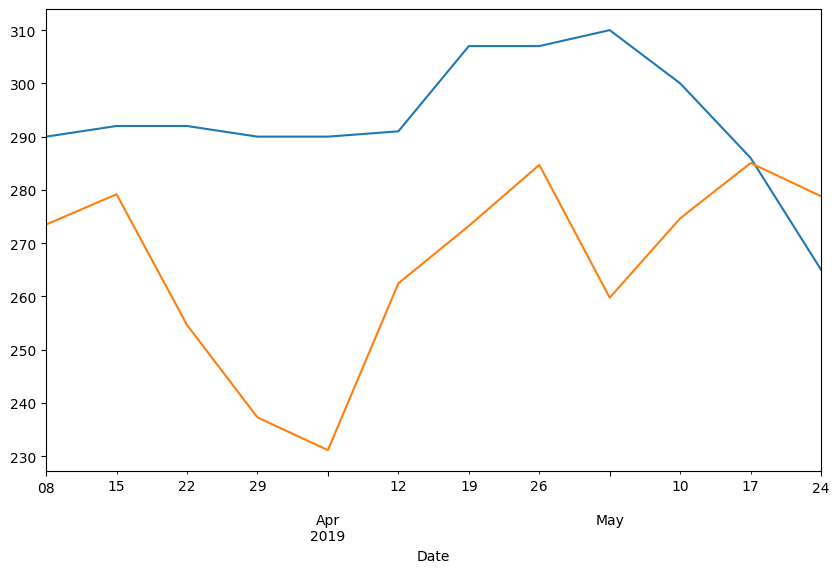

In [120]:
df_predictions1['India Price'].plot(figsize=(10,6))
df_predictions1['IndiaPrice_pred'].plot()

In [121]:
from sklearn.metrics import mean_squared_error
from math import sqrt
error1=sqrt(mean_squared_error(df_predictions1['India Price'],df_predictions1['IndiaPrice_pred']))
print(error1)

34.01724513830555


In [145]:
# Calculate range of test set
range_test = test.max() - test.min()

# Calculate Normalized RMSE
normalized_rmse = error1 / range_test

print(normalized_rmse)

India Price          0.106470
Asia Price           0.120629
Rotterdam Price      0.136178
US Domestic Price    0.479454
dtype: float64


In [122]:
test3_input=data[726:738]
test3_input_scaled=scaler.fit_transform(test3_input)

In [123]:
test_pred2=data[738:750]

In [124]:
test_predictions2=[]
n_input=12
n_features=4
first_batch2=test3_input_scaled
curr_batch2=first_batch2.reshape((1,n_input,n_features))
for i in range(0,len(test_pred2)):#len(test_pred)
  curr_pred2=model.predict(curr_batch2)[0]
  test_predictions2.append(curr_pred2)
  slc=pred(i,curr_pred2,curr_batch2)
  curr_batch2=np.append(curr_batch2[:,1:,:],[[slc]],axis=1)

1/1 [==============================] - 0s 29ms/step


In [125]:
curr_batch2

array([[[0.38124403, 0.03296703, 0.        , 0.27047913],
        [0.18385918, 0.16483516, 0.13513514, 0.        ],
        [0.13601033, 0.50549451, 0.2652027 , 0.        ],
        [0.27429479, 1.        , 0.78378378, 0.        ],
        [0.64064991, 0.23076923, 0.55574324, 0.81530139],
        [0.43169373, 0.0989011 , 0.73817568, 0.81530139],
        [0.38205835, 0.03296703, 0.        , 0.27047913],
        [0.14165699, 0.50549451, 0.2652027 , 0.        ],
        [0.23432419, 0.23076923, 0.55574324, 0.81530139],
        [0.32842574, 0.03296703, 0.        , 0.27047913],
        [0.16045508, 0.23076923, 0.55574324, 0.81530139],
        [0.30124149, 0.23076923, 0.55574324, 0.81530139]]])

In [126]:
test_predictions2=np.array(test_predictions2)
type(test_predictions2)

numpy.ndarray

In [127]:
curr_batch2=curr_batch2.reshape(n_input,n_features)
curr_batch2.shape

(12, 4)

In [128]:
true_predictions2=scaler.inverse_transform(curr_batch2)
true_predictions2

array([[209.86851731, 247.        , 201.6       ,  80.19      ],
       [202.17050819, 259.        , 209.6       ,  76.69      ],
       [200.30440302, 290.        , 217.3       ,  76.69      ],
       [205.69749695, 335.        , 248.        ,  76.69      ],
       [219.98534667, 265.        , 234.5       ,  87.24      ],
       [211.83605558, 253.        , 245.3       ,  87.24      ],
       [209.90027574, 247.        , 201.6       ,  80.19      ],
       [200.5246228 , 290.        , 217.3       ,  76.69      ],
       [204.13864329, 265.        , 234.5       ,  87.24      ],
       [207.80860367, 247.        , 201.6       ,  80.19      ],
       [201.25774804, 265.        , 234.5       ,  87.24      ],
       [206.748418  , 265.        , 234.5       ,  87.24      ]])

In [129]:
df_predictions2=test_pred2
df_predictions2
df_predictions2['IndiaPrice_pred']=true_predictions2[:,0]

<ipython-input-129-a62c74056f6d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_predictions2['IndiaPrice_pred']=true_predictions2[:,0]


In [130]:
df_predictions2

,India Price,Asia Price,Rotterdam Price,US Domestic Price,IndiaPrice_pred
Date,,,,,
2020-03-06,200.0,261.0,246.60,89.63,209.868517
2020-03-13,189.0,241.0,211.20,89.63,202.170508
2020-03-20,182.0,229.0,180.20,89.63,200.304403
2020-03-27,172.0,214.0,165.30,79.88,205.697497
2020-04-03,156.0,182.0,152.20,79.88,219.985347
2020-04-10,152.0,183.0,149.50,79.88,211.836056
2020-04-17,152.0,179.0,152.00,79.88,209.900276
2020-04-24,147.0,178.0,154.00,79.88,200.524623
2020-05-01,148.0,178.0,147.20,70.13,204.138643


<Axes: xlabel='Date'>

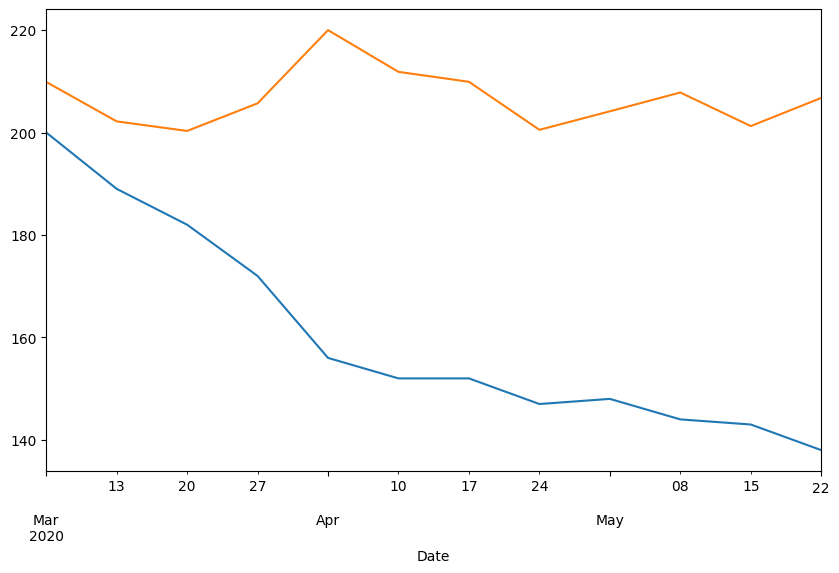

In [131]:
df_predictions2['India Price'].plot(figsize=(10,6))
df_predictions2['IndiaPrice_pred'].plot()

In [132]:
error2=sqrt(mean_squared_error(df_predictions2['India Price'],df_predictions2['IndiaPrice_pred']))
print(error2)

50.80733465831527


In [144]:
# Calculate range of test set
range_test = test.max() - test.min()

# Calculate Normalized RMSE
normalized_rmse = error2 / range_test

print(normalized_rmse)

India Price          0.159021
Asia Price           0.180168
Rotterdam Price      0.203392
US Domestic Price    0.716101
dtype: float64


In [133]:
test4_input=data[772:784]
test4_input_scaled=scaler.fit_transform(test4_input)
test_pred3=data[784:796]

In [134]:
test_predictions3=[]
n_input=12
n_features=4
first_batch3=test4_input_scaled
curr_batch3=first_batch3.reshape((1,n_input,n_features))
for i in range(0,len(test_pred3)):#len(test_pred)
  curr_pred3=model.predict(curr_batch3)[0]
  test_predictions3.append(curr_pred3)
  slc=pred(i,curr_pred3,curr_batch3)
  curr_batch3=np.append(curr_batch3[:,1:,:],[[slc]],axis=1)

1/1 [==============================] - 0s 41ms/step


In [135]:
curr_batch3

array([[[0.81776667, 0.        , 0.        , 0.        ],
        [0.28830868, 0.16      , 0.14134615, 0.21575758],
        [0.01058936, 0.2       , 0.47211538, 0.21575758],
        [0.01784387, 0.44      , 0.86057692, 0.43181818],
        [0.39321733, 0.96      , 1.        , 1.        ],
        [0.66067147, 1.        , 0.73173077, 1.        ],
        [0.64127213, 0.        , 0.        , 0.        ],
        [0.31953356, 0.2       , 0.47211538, 0.21575758],
        [0.3249222 , 0.96      , 1.        , 1.        ],
        [0.67065954, 0.        , 0.        , 0.        ],
        [0.28507659, 0.96      , 1.        , 1.        ],
        [0.64369965, 0.96      , 1.        , 1.        ]]])

In [136]:
test_predictions3=np.array(test_predictions3)
type(test_predictions3)

numpy.ndarray

In [137]:
curr_batch3=curr_batch3.reshape(n_input,n_features)
curr_batch3.shape

(12, 4)

In [138]:
true_predictions3=scaler.inverse_transform(curr_batch3)
true_predictions3

array([[277.41676664, 260.        , 239.1       ,  76.88      ],
       [229.23608989, 280.        , 253.8       ,  84.        ],
       [203.96363187, 285.        , 288.2       ,  84.        ],
       [204.62379238, 315.        , 328.6       ,  91.13      ],
       [238.78277659, 380.        , 343.1       , 109.88      ],
       [263.121104  , 385.        , 315.2       , 109.88      ],
       [261.35576361, 260.        , 239.1       ,  76.88      ],
       [232.07755366, 285.        , 288.2       ,  84.        ],
       [232.56792057, 380.        , 343.1       , 109.88      ],
       [264.03001833, 260.        , 239.1       ,  76.88      ],
       [228.94196954, 380.        , 343.1       , 109.88      ],
       [261.57666779, 380.        , 343.1       , 109.88      ]])

In [139]:
df_predictions3=test_pred3
df_predictions3
df_predictions3['IndiaPrice_pred']=true_predictions3[:,0]

<ipython-input-139-9486bbec8021>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_predictions3['IndiaPrice_pred']=true_predictions3[:,0]


In [140]:
df_predictions3

,India Price,Asia Price,Rotterdam Price,US Domestic Price,IndiaPrice_pred
Date,,,,,
2021-02-05,282.0,385.0,346.50,111.00,277.416767
2021-02-12,282.0,385.0,335.90,111.00,229.236090
2021-02-19,282.0,374.0,330.50,111.00,203.963632
2021-02-26,284.0,382.0,340.00,111.00,204.623792
2021-03-05,289.0,387.0,331.90,112.88,238.782777
2021-03-12,283.0,370.0,326.40,112.88,263.121104
2021-03-19,281.0,370.0,319.60,112.88,261.355764
2021-03-26,274.0,370.0,316.40,112.88,232.077554
2021-04-02,274.0,365.0,316.75,117.75,232.567921


<Axes: xlabel='Date'>

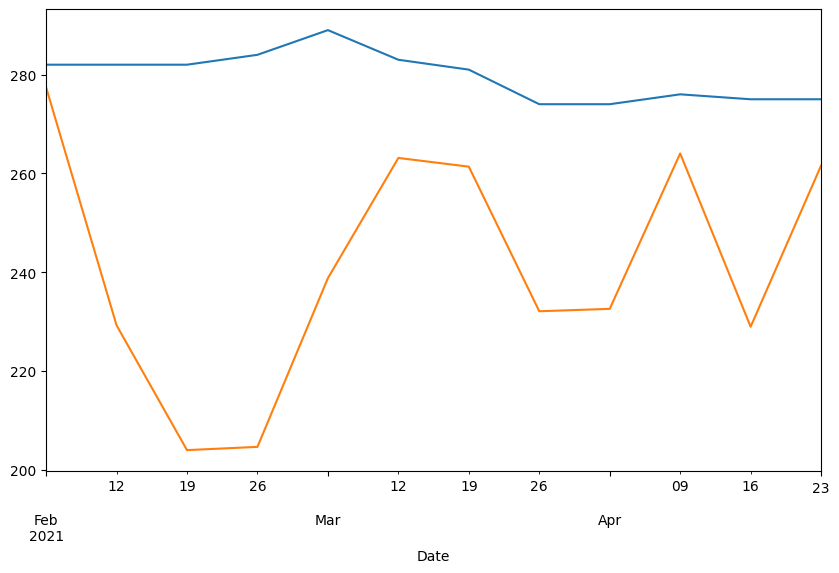

In [141]:
df_predictions3['India Price'].plot(figsize=(10,6))
df_predictions3['IndiaPrice_pred'].plot()

In [142]:
error3=sqrt(mean_squared_error(df_predictions3['India Price'],df_predictions3['IndiaPrice_pred']))
print(error3)

45.10824626534697


In [143]:
# Calculate range of test set
range_test = test.max() - test.min()

# Calculate Normalized RMSE
normalized_rmse = error3 / range_test

print(normalized_rmse)

India Price          0.141184
Asia Price           0.159958
Rotterdam Price      0.180577
US Domestic Price    0.635775
dtype: float64
